# Data Scientist Professional Practical Exam Submission

**Use this template to write up your summary for submission. Code in Python or R needs to be included.**


## 📝 Task List

Your written report should include both code, output and written text summaries of the following:
- Data Validation:   
  - Describe validation and cleaning steps for every column in the data 
- Exploratory Analysis:  
  - Include two different graphics showing single variables only to demonstrate the characteristics of data  
  - Include at least one graphic showing two or more variables to represent the relationship between features
  - Describe your findings
- Model Development
  - Include your reasons for selecting the models you use as well as a statement of the problem type
  - Code to fit the baseline and comparison models
- Model Evaluation
  - Describe the performance of the two models based on an appropriate metric
- Business Metrics
  - Define a way to compare your model performance to the business
  - Describe how your models perform using this approach
- Final summary including recommendations that the business should undertake

*Start writing report here..*

# Data Validation
As shown in the code block below, several validation and cleaning steps had to be undertaken to prepare the data for processing. These include:
- Turning the high-traffic metric into a boolean (0 or 1)
- Changing the data type of the servings column from `object` to `int`
- Cleaning and one-hot encoding the category column
- Dropping missing rows (see following text block)

In [6]:
### Import and clean data

# Import librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def process(csv):
    # Read csv
    df = pd.read_csv(csv)

    # Make high_traffic boolean
    df.loc[df.high_traffic != 'High','high_traffic'] = 0
    df.loc[df.high_traffic == 'High','high_traffic'] = 1
    df.high_traffic = df.high_traffic.astype('int')

    # Clean servings column and convert to int
    df.servings = df.servings.str[:1].astype('int')

    # Convert chicken breast category to chicken
    df.loc[df.category == 'Chicken Breast','category'] = 'Chicken'

    # One-hot encode category
    df = pd.concat([df,pd.get_dummies(df.category)],axis=1)

    # Drop missing (see below)
    df.dropna(how='any',inplace=True)

    return df
    
df = process('recipe_site_traffic_2212.csv')
df

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic,Beverages,Breakfast,Chicken,Dessert,Lunch/Snacks,Meat,One Dish Meal,Pork,Potato,Vegetable
1,2,35.48,38.56,0.66,0.92,Potato,4,1,False,False,False,False,False,False,False,False,True,False
2,3,914.28,42.68,3.09,2.88,Breakfast,1,0,False,True,False,False,False,False,False,False,False,False
3,4,97.03,30.56,38.63,0.02,Beverages,4,1,True,False,False,False,False,False,False,False,False,False
4,5,27.05,1.85,0.80,0.53,Beverages,4,0,True,False,False,False,False,False,False,False,False,False
5,6,691.15,3.46,1.65,53.93,One Dish Meal,2,1,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
941,942,186.21,83.94,1.98,22.40,Chicken,4,1,False,False,True,False,False,False,False,False,False,False
942,943,1161.00,5.31,22.39,44.22,Lunch/Snacks,2,0,False,False,False,False,True,False,False,False,False,False
944,945,951.74,29.42,3.57,13.87,Pork,2,1,False,False,False,False,False,False,False,True,False,False
945,946,266.61,35.77,0.97,8.07,Potato,6,1,False,False,False,False,False,False,False,False,True,False


## Missing data
When a row is missing data, it tends to be missing all of the quantitative features (calories, carbs, sugar, and protein). This means that if we were to fill these missing points, we would have to impute all four features from just the serving size and category. This yielded very sparse and dubious results.

Only 5% of the data is missing these four features, and the proportion of high traffic recipes in this missing dataset is similar to that of the whole dataframe (75% vs 60%), therefore it was decided that these points should just be dropped to avoid introducing bias into the model.

# Exploratory Analysis
## Figure 1: Pairplot of quantitative features
As shown by the graph, it is not immediately obvious whether there exists any kind of correlation between the quantitative features.

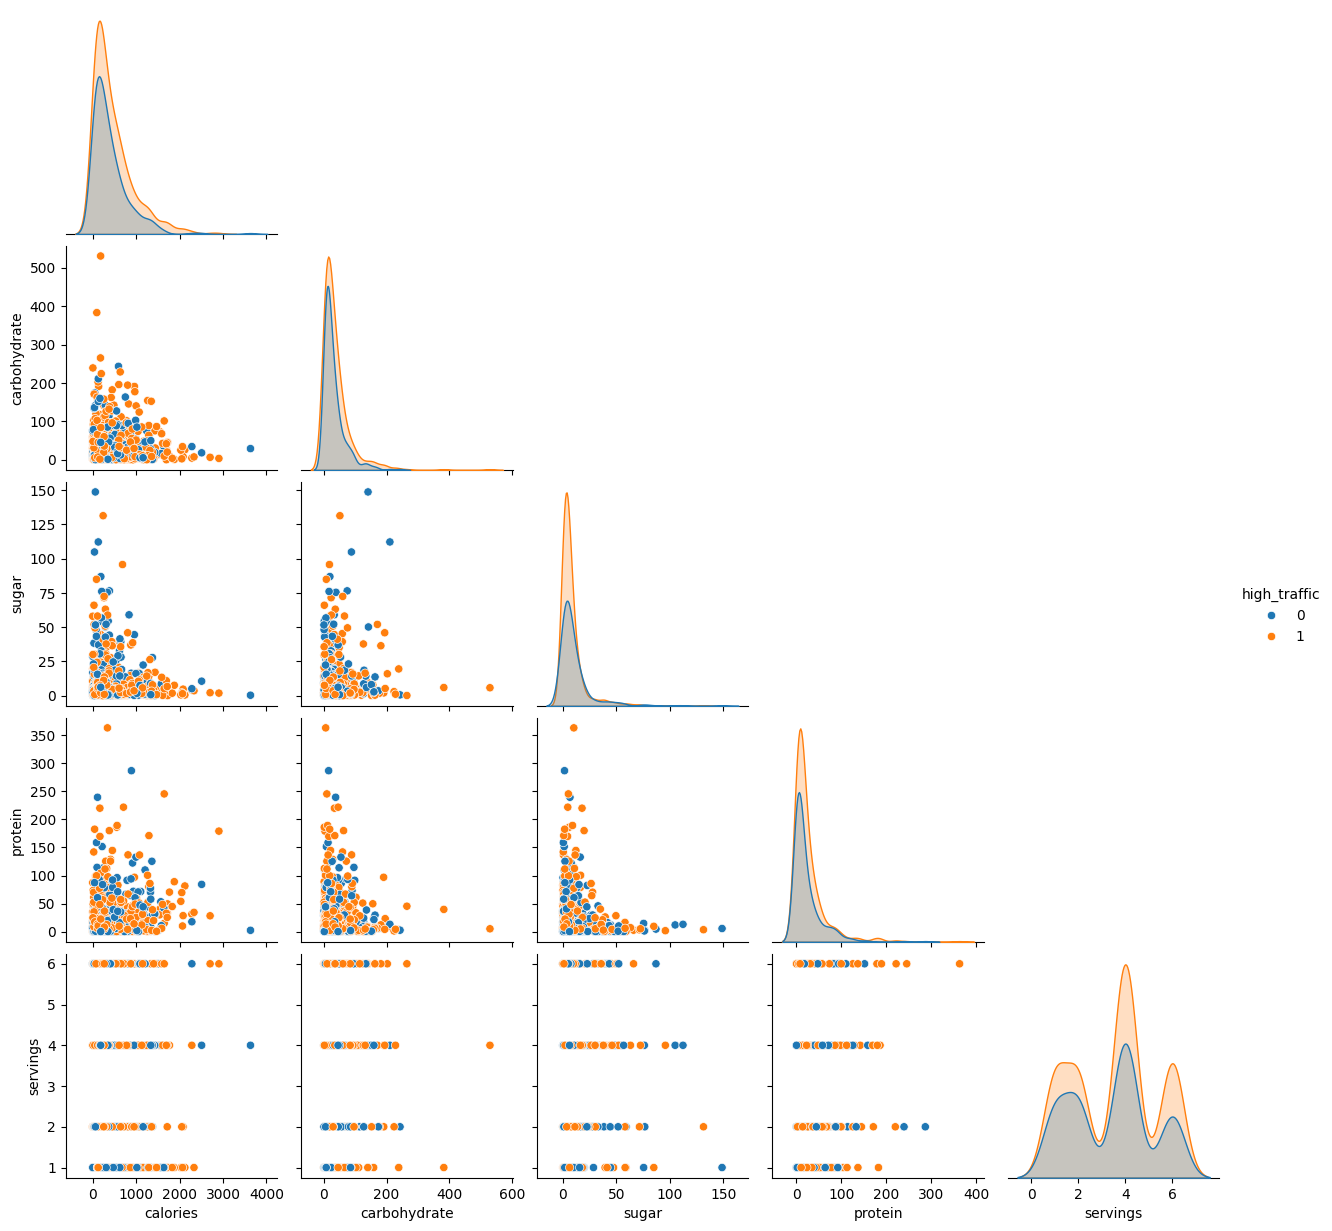

In [7]:
# Figure 1: Pairplot of quantitative features
sns.pairplot(data=df,vars=['calories', 'carbohydrate', 'sugar', 'protein', 'servings'],hue='high_traffic',corner=True)

plt.savefig('pairplot.png',dpi=200,bbox_inches='tight')
plt.show()

## Figure 2: Servings Histogram
In this figure, the distribution of serving sizes is shown, with the proportion of high traffic recipes overlayed on top. Each serving size has a proportion of about 60% high traffic recipes, so the serving size is unlikely to be particularly relevant in the model fitting.

C:\Users\jeanm\AppData\Local\Temp\ipykernel_7120\1719978429.py:2: UserWarning: The palette list has more values (12) than needed (2), which may not be intended.
  sns.histplot(data=df,x='servings',hue='high_traffic', discrete=True, multiple='stack', palette=sns.color_palette("Paired"))


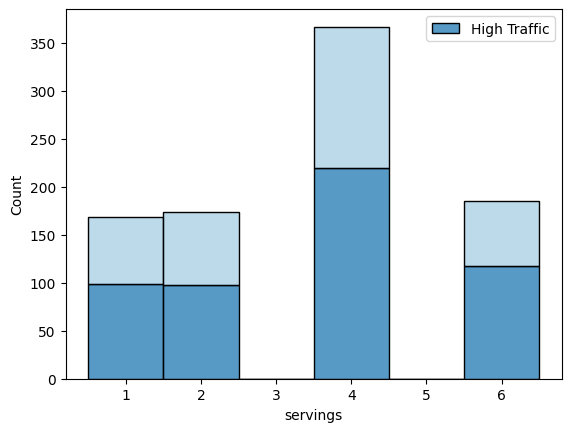

In [8]:
# Figure 2: Servings Histogram
sns.histplot(data=df,x='servings',hue='high_traffic', discrete=True, multiple='stack', palette=sns.color_palette("Paired"))
plt.legend(labels=['High Traffic'])

plt.savefig('servings_hist.png',dpi=200,bbox_inches='tight')
plt.show()

## Figure 3: Category popularity
Figure 3 is a nested pie chart with the outer wedges representing the proportion of each category of recipe, and the inner wedges representing the proportion of high traffic recipes within each category.
There is a roughly uniform distribution of recipe types, however how successful they are does vary. Vegetable, Potato and Pork recipes are three most popular recipe types, with at least 90% of each recipe type generating high traffic.

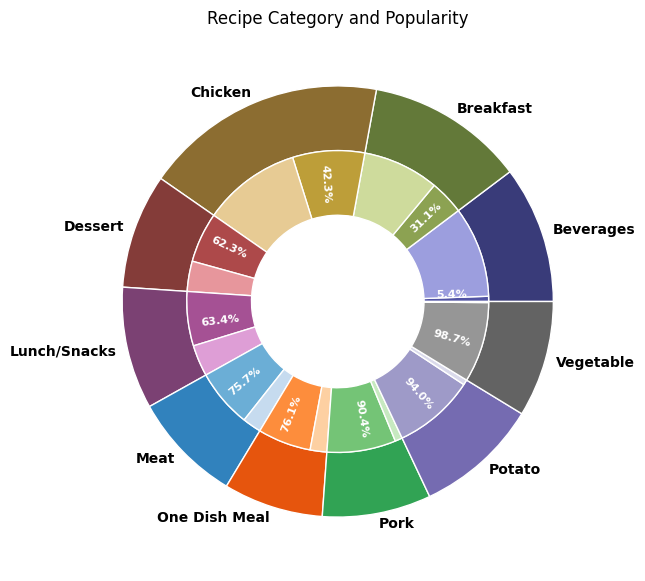

In [9]:
# Figure 3: Category popularity
import matplotlib.pyplot as plt

# Create data
recipe_counts = pd.DataFrame({'total': df.groupby('category').count().recipe})
for cat in recipe_counts.index:
    recipe_counts.loc[cat,'high_perc'] = df.loc[df.category == cat,'high_traffic'].sum() / \
                                            recipe_counts.loc[cat,'total']
recipe_counts['scale_high'] = recipe_counts['high_perc'] * recipe_counts['total']
recipe_counts['scale_low'] = recipe_counts['total'] - recipe_counts['scale_high']

# Create plot
fig, ax = plt.subplots(figsize=(7,7))

# Set size of wedges
size = 0.3

# Set colors of wedges, with lighter inner shades
outer_colors = np.vstack((plt.colormaps["tab20b"](np.arange(5)*4),
                          plt.colormaps["tab20c"](np.arange(5)*4)))
inner_colors = np.vstack((plt.colormaps["tab20b"](
                            [4*x+2*y+1 for x in range(5) for y in range(2)]),
                          plt.colormaps["tab20c"](
                            [4*x+2*y+1 for x in range(5) for y in range(2)])))

# Draw outer plot
wedges_out, texts_out = ax.pie(recipe_counts['total'],
                               labels=recipe_counts.index,
                               radius=1,
                               colors=outer_colors,
                               wedgeprops=dict(width=size, edgecolor='w'),
                               labeldistance=1.05)

# Draw inner plot
wedges_in, texts_in = ax.pie(recipe_counts[['scale_high','scale_low']].to_numpy().flatten(),
                             labels=np.array([[str(round(recipe_counts.loc[c,'high_perc']*100,1))+'%','']
                                              for c in recipe_counts.index]).flatten(),
                             radius=1-size,
                             colors=inner_colors,
                             wedgeprops=dict(width=size, edgecolor='w'),
                             labeldistance=.65,
                             rotatelabels=True)

plt.setp(texts_out, size=10, weight="bold")
plt.setp(texts_in, size=8, weight="bold", color='white')
plt.title('Recipe Category and Popularity')

plt.savefig('nested_pie.png',dpi=200,bbox_inches='tight')
plt.show()

# Baseline models
The key metric to be looking at here is the precision for high-traffic recipes (label = 1). This is because the customer has requested that at least 80% of the recipes chosen are high-traffic. From the table above it is clear that naive baseline models would not meet this requirement, and a more sophisticated model is necessary.

In [10]:
# Baseline model(s)
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report

# Split data
df = process('recipe_site_traffic_2212.csv').drop(columns='category')
X_train, X_test, y_train, y_test = train_test_split(
    df.loc[:,df.columns != 'high_traffic'], df['high_traffic'], random_state=42)

# Generate classification reports for various dummy classifiers
for strat in ["most_frequent", "stratified", "uniform"]:

    # Fit dummy classifier
    dummy_clf = DummyClassifier(strategy=strat, random_state=42)
    dummy_clf.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = dummy_clf.predict(X_test)
    print('Strategy: ',strat)
    print(classification_report(y_test, y_pred))

Strategy:  most_frequent
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        90
           1       0.60      1.00      0.75       134

    accuracy                           0.60       224
   macro avg       0.30      0.50      0.37       224
weighted avg       0.36      0.60      0.45       224

Strategy:  stratified
              precision    recall  f1-score   support

           0       0.48      0.49      0.49        90
           1       0.65      0.65      0.65       134

    accuracy                           0.58       224
   macro avg       0.57      0.57      0.57       224
weighted avg       0.59      0.58      0.59       224

Strategy:  uniform
              precision    recall  f1-score   support

           0       0.42      0.53      0.47        90
           1       0.61      0.50      0.55       134

    accuracy                           0.51       224
   macro avg       0.52      0.52      0.51       224
weighted

c:\Users\jeanm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jeanm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jeanm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

# Advanced Model
## Logistic Regression (default)
Logistic Regression is an simple, fast, and efficient tool for binary classification models. RandomizedSearchCV was used to tune the hyperparameters, however the default settings were found to be not far from optimal, with only the maximum number of iterations `max_iter` being adjusted.

In [11]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=200)
clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.59      0.65        90
           1       0.76      0.86      0.80       134

    accuracy                           0.75       224
   macro avg       0.75      0.72      0.73       224
weighted avg       0.75      0.75      0.74       224



c:\Users\jeanm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Class Weights
As shown above, the precision has increased to 77%, however this value does not yet meet the client's requirement.
This is because the model, as implemented here, seeks to maximise the average of the precision across each class.
The precision of high-traffic can be prioritised (at the expense of the low-traffic precision, which does not matter to the client) by adjusting the class weights. Intuitively, this adjusts the probability threshold for labelling datapoints.

A variety of weight ratios are tested, from 1:1 to 3:1. As the precision (i.e. number of true positives / true and false positives) increases, the number of recipes predicted as high-traffic decreases as well. Using a weight ratio of 3:1 increases precision from 77% to 89%, but nearly halves the number of suggested recipes, from 65% of the test set to 36%.

In [12]:
from sklearn.metrics import precision_score

df_weights = pd.DataFrame(columns = ['weights','precision','perc_labelled'])
df_weights['weights'] = np.arange(1,3.5,.5)
y_preds = [[]] * len(df_weights['weights'])

for i,w in enumerate(df_weights['weights']):
    y_preds[i] = LogisticRegression(max_iter=200, class_weight = {0: w, 1: 1}).fit(X_train,y_train).predict(X_test)
    df_weights.loc[i,'precision'] = precision_score(y_test,y_preds[i])
    df_weights.loc[i,'perc_labelled'] = y_preds[i].sum() / len(y_preds[i])

df_weights

c:\Users\jeanm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\jeanm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

,weights,precision,perc_labelled
0,1.0,0.756579,0.678571
1,1.5,0.793103,0.517857
2,2.0,0.823529,0.455357
3,2.5,0.863158,0.424107
4,3.0,0.875,0.357143


# Business metrics
It is therefore up to the client to find the optimal balance between precision and quantity of recipes eligible for displaying on the home page. This tradeoff is illustrated in the graph below, where a class weight of 2 or higher provides the desired results. If there is a greater emphasis on precision, and the client does not need many recipes to choose from, then a class weight of 3 or higher can be chosen. This latter option is recommended due to the variance in dataset.

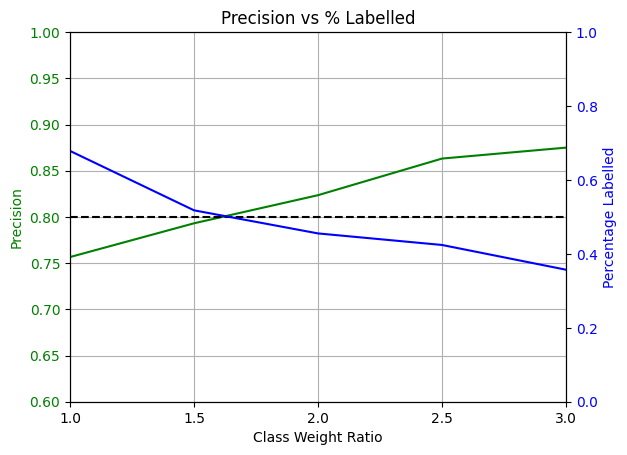

In [13]:
# Figure 4: Precision vs Percentage Labelled
fig,ax1 = plt.subplots()
ax2 = ax1.twinx()
leftc = 'green'
rightc = 'blue'

ax1.plot(df_weights.weights,df_weights.precision, color=leftc)
ax1.hlines(y=.8,xmin=1,xmax=3, colors='black', linestyles='dashed')
ax2.plot(df_weights.weights,df_weights.perc_labelled, color=rightc)

ax1.set_xlim(1,3)
ax1.set_ylim(.6,1)
ax2.set_ylim(0,1)

# ax1.set_ylim(0,1)
# ax2.set_ylim(0,1)

ax1.xaxis.set_ticks(df_weights.weights)
ax1.set_xlabel('Class Weight Ratio')
ax1.set_ylabel('Precision',color=leftc)
ax1.tick_params(axis='y',labelcolor=leftc)
ax2.set_ylabel('Percentage Labelled',color=rightc)
ax2.tick_params(axis='y',labelcolor=rightc)
ax1.grid()
plt.title('Precision vs % Labelled')

plt.savefig('prec_v_perc.png',dpi=200,bbox_inches='tight')
plt.show()

# Further Analysis of Predictions
In this section, the predictions generated by the Logistic Regression model are explored, in particular what characterises the recipes chosen by the model to be displayed on the home page.

The pie chart on the left shows the distribution of recipe types for equal class weights, and on the right for 3:1 class weights. The titles also reference the precision scores from Fig. 4 above.

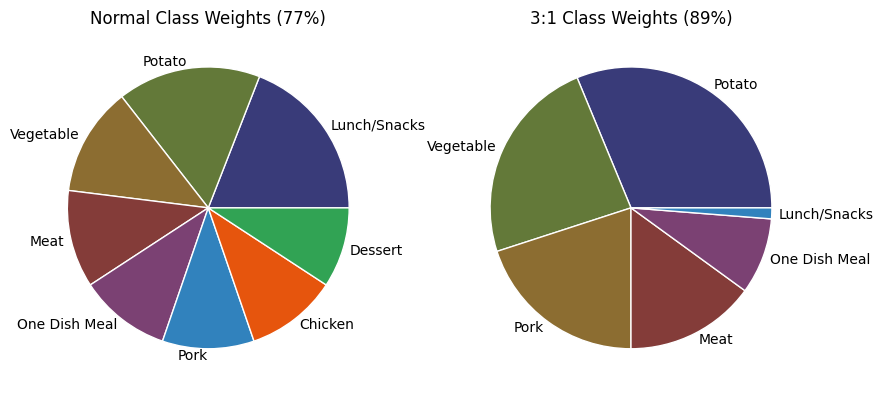

In [17]:
# Figure 5: Predicted Category Distribution
import matplotlib.pyplot as plt

# Create data
categories = ['Beverages', 'Breakfast', 'Chicken', 'Dessert', 'Lunch/Snacks', 'Meat', 
              'One Dish Meal', 'Pork', 'Potato', 'Vegetable']
X_test['category'] = X_test[categories].idxmax(axis=1)
X_test['high_traffic_w1'] = y_preds[0]
X_test['high_traffic_w3'] = y_preds[4]

# Create plot
fig, axs = plt.subplots(1,2,figsize=(10,10))

# Colors
outer_colors = np.vstack((plt.colormaps["tab20b"](np.arange(5)*4),
                          plt.colormaps["tab20c"](np.arange(5)*4)))

# Draw outer plot
wedges1, texts1 = axs[0].pie(X_test.loc[X_test.high_traffic_w1 == 1, 'category'].value_counts(),
                        labels=X_test.loc[X_test.high_traffic_w1 == 1, 'category'].value_counts().index,
                        radius=1,
                        colors=outer_colors,
                        wedgeprops=dict(edgecolor='w'),
                        labeldistance=1.05)

wedges2, texts2 = axs[1].pie(X_test.loc[X_test.high_traffic_w3 == 1, 'category'].value_counts(),
                        labels=X_test.loc[X_test.high_traffic_w3 == 1, 'category'].value_counts().index,
                        radius=1,
                        colors=outer_colors,
                        wedgeprops=dict(edgecolor='w'),
                        labeldistance=1.05)

axs[0].set_title('Normal Class Weights (77%)')
axs[1].set_title('3:1 Class Weights (89%)')
plt.setp(texts1, size=10)
plt.setp(texts2, size=10)

plt.savefig('two_pies.png',dpi=200,bbox_inches='tight')
plt.show()

## Analysis and Custom Predictions
The motivation for Fig. 5 above stemmed from an observation made in Fig. 3, where three categories had exceptionally high success rates (Vegetable, Potato, and Pork). The figure above attempts to make clear just how many of the recipes predicted belong to these three categories. Unsurprisingly, in the version of the model that prioritizes accuracy over quantity, these three categories are heavily sampled.

In fact, this observation could underpin another potential naive/dummy/baseline classifier, which would automatically classify recipes as high-traffic if they are Vegetable, Potato, or Pork-based. It clocked in at 93.3% precision.

In [15]:
# Custom prediction ("Top-3")
categories = ['Beverages', 'Breakfast', 'Chicken', 'Dessert', 'Lunch/Snacks', 'Meat', 
              'One Dish Meal', 'Pork', 'Potato', 'Vegetable']
X_test['category'] = X_test[categories].idxmax(axis=1)
custom_pred = np.array([0] * len(X_test))
custom_pred[X_test.category.isin(['Vegetable','Potato','Pork'])] = 1
print('Precision Score for Top 3-naive classifier: ', round(precision_score(y_test,custom_pred)*100,1), '%')

Precision Score for Top 3-naive classifier:  93.3 %


Although this is a very high for precision, it should be noted that this model is very inflexible and would automatically disqualify 7 out of the 10 recipe categories, which could lead to a diminished and repetitive website. The logistic regression 3:1 model seems to strike a more appropriate balance between precision and quantity of high-traffic-labeled recipes.

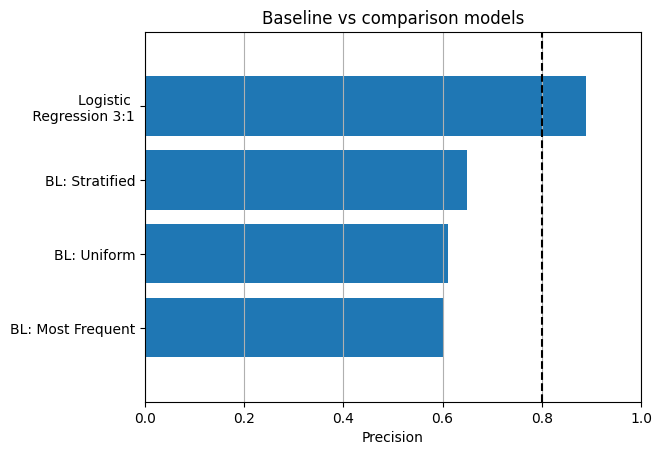

In [16]:
# Figure 6: Baseline vs comparison models
df_comp = pd.DataFrame({'model': ['Logistic \n Regression 3:1', 'BL: Stratified',
                                  'BL: Uniform', 'BL: Most Frequent'], 
                        'precision': [.89,.65,.61,.6]})
df_comp.sort_values(by='precision',inplace=True)
fig, ax = plt.subplots()
plt.barh(df_comp.model,df_comp.precision)
plt.vlines(.8,-1,4,color='black',linestyles='dashed')
ax.set_ylim(-1,4)
ax.set_xlim(0,1)
ax.grid(axis='x')
ax.set_xlabel('Precision')
plt.title('Baseline vs comparison models')

plt.savefig('final_comp.png',dpi=200,bbox_inches='tight',transparent=True)
plt.show()

# Conclusions
It is recommended to the business to use a Logistic Regression model with class weights adjusted to prioritise precision in high-traffic recipe predictions. With this model, approximately 90% of the recipes predicted to be high-traffic will result in increased traffic to the site. This should enable the client fto increase traffic to the rest of the website by as much as 40% and increase the number of subscriptions.

## ✅ When you have finished...
-  Publish your Workspace using the option on the left
-  Check the published version of your report:
	-  Can you see everything you want us to grade?
    -  Are all the graphics visible?
-  Review the grading rubric. Have you included everything that will be graded?
-  Head back to the [Certification Dashboard](https://app.datacamp.com/certification) to submit your practical exam report and record your presentation